<a href="https://colab.research.google.com/github/tsachiblau/Urban-point-clouds-Classification/blob/master/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up

In [0]:
from keras.optimizers import Adam
import numpy as np

#set seed
np.random.seed(10)

#train params
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 10
optimizer = Adam(0.0002, 0.5)

#gan param
noise_dim = 100

#images params
img_rows, img_cols, channels = 28, 28, 1
batch_size = 16

#sparse params
sparse_dim = img_rows * img_cols * channels
L1_weight = 0.01   # Loss = data_fidelity + L1_weight * L1_norm
max_iter_of_dict = 1

import data set

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

np.random.shuffle(x_train)
print(x_train.shape)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 784)


*Train* or load sparse dictionary:

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path

#dictionary file name
file_path = 'dictionary.pkl'
retrain_model = False

#check if dictionary exists
if not path.exists(file_path):
  max_iter_of_dict = 1
  sparse_dim = 3000
  d=DictionaryLearning(n_components=sparse_dim, max_iter=max_iter_of_dict)
  # train dictionary
  d.fit(x_train[1:10000, :])
  dictionary = d.components_
  print(dictionary.shape)

  with open(file_path, 'wb') as output:
    pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
  print("created new dictionary")

else:
  with open(file_path, 'rb') as input:
    d = pickle.load(input)
  # print(d)
  print("loaded dictionary")

  if retrain_model == True:
    max_iter_of_dict = 40
    print("start retrain for ", str(max_iter_of_dict), " iteration")
    d.fit(x_train[1:10000, :])
    dictionary = d.components_
    print(dictionary.shape)
    print("train for ", str(max_iter_of_dict) ," more iter")
    file_path = 'new_dictionary.pkl'
    with open(file_path, 'wb') as output:
      pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
    print("created new dictionary")



dictionary_loaded2 = np.transpose(d.components_)
dictionary_loaded2 = np.array(dictionary_loaded2, dtype = np.float32)
print(dictionary_loaded2.shape)


loaded dictionary
(784, 784)


**sanity** check

In [0]:
def imageToDictionaryImage(d, X):
  representation_vec = d.transform(X)
  representation_vec = np.transpose(representation_vec)
  ans = np.matmul(dictionary_loaded2,representation_vec)
  return ans

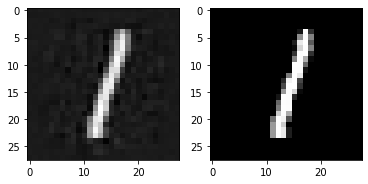

In [12]:

sample_num = np.random.randint(x_train.shape[0])

ans = imageToDictionaryImage(d, x_train[sample_num:sample_num+1,:])

plt.figure()
plt.subplot(121)
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')
plt.subplot(122)
real_im = x_train[sample_num:sample_num+1,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')



extend dataset


In [19]:
new_data_name = 'new_data'
N = x_train.shape[0]

if path.exists(new_data_name):
  x_train = np.load(new_data_name)
  print("loaded new data")

else:

  #create the data
  new_images = []
  for i in range(N):
    new_images.append(imageToDictionaryImage(d, x_train[i:i + 1,:]))
    
    if np.mod(i, 1000) == 0:
      print("finished ", str(i), "/", str(N))
  
  #save it 
  a = np.array(new_images)
  a = a.reshape(a.shape[0], a.shape[1])
  x_train = a

  np.save(new_data_name, x_train)
  print("saved the new data")

finished  0 / 60000
finished  1000 / 60000
finished  2000 / 60000
finished  3000 / 60000
finished  4000 / 60000
finished  5000 / 60000
finished  6000 / 60000
finished  7000 / 60000
finished  8000 / 60000
finished  9000 / 60000
finished  10000 / 60000
finished  11000 / 60000
finished  12000 / 60000
finished  13000 / 60000
finished  14000 / 60000
finished  15000 / 60000
finished  16000 / 60000
finished  17000 / 60000
finished  18000 / 60000
finished  19000 / 60000
finished  20000 / 60000
finished  21000 / 60000
finished  22000 / 60000
finished  23000 / 60000
finished  24000 / 60000
finished  25000 / 60000
finished  26000 / 60000
finished  27000 / 60000
finished  28000 / 60000
finished  29000 / 60000
finished  30000 / 60000
finished  31000 / 60000
finished  32000 / 60000
finished  33000 / 60000
finished  34000 / 60000
finished  35000 / 60000
finished  36000 / 60000
finished  37000 / 60000
finished  38000 / 60000
finished  39000 / 60000
finished  40000 / 60000
finished  41000 / 60000
finis

(60000, 784)


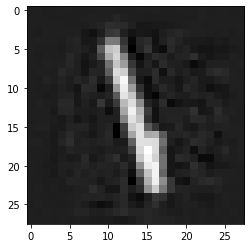

In [45]:
#show new data 
random_num = np.random.randint(N)

tmp_img = a[random_num, :]
plt.figure()
plt.imshow(tmp_img.reshape((img_rows, img_cols)), cmap='gray')



In [0]:
def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



extende dataset

In [41]:
# with pursuit and thresholding approach
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.linalg import matmul, matrix_transpose

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    #reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(Dense(512, input_dim=sparse_dim))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(sparse_dim, activation='tanh'))
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))))(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels))(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=['binary_crossentropy','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2nd approach train

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1 	 Discriminator Loss_fake: 0.34780585765838623 	 Discriminator Loss_real: 0.02370980568230152		 Generator Loss: [3.869607, 3.863629, 0.59779257] 		 Reconstructor Loss: 0.9770202040672302 		 num_of_non_zeros: 363.55226666666664


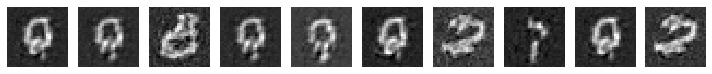

Epoch: 2 	 Discriminator Loss_fake: 0.3384612798690796 	 Discriminator Loss_real: 0.0013316101394593716		 Generator Loss: [7.735977, 7.7297277, 0.6249268] 		 Reconstructor Loss: 0.9903497695922852 		 num_of_non_zeros: 363.0412666666667


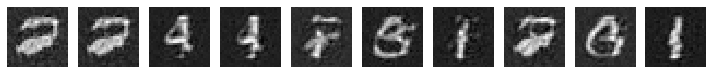

Epoch: 3 	 Discriminator Loss_fake: 0.3476777672767639 	 Discriminator Loss_real: 0.007091102190315723		 Generator Loss: [5.118575, 5.1122503, 0.63249993] 		 Reconstructor Loss: 0.9824197888374329 		 num_of_non_zeros: 358.7415833333333


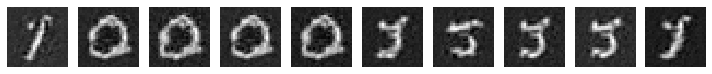

In [0]:
import matplotlib.pyplot as plt

for epoch in range(epochs):  #epochs
    num_of_non_zeros = 0
    
    for batch in range(steps_per_epoch):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)
        num_of_non_zeros = num_of_non_zeros + np.count_nonzero( fake_x[fake_x>0.1] )
        # fake is (batch_size,sparse_dim)
        
        fake_x = np.transpose(fake_x)
        # thresholding
        
        # multiply by dict
        fake_x = np.matmul(dictionary_loaded2,fake_x)
        fake_x = np.transpose(fake_x)
        fake_x = fake_x.reshape(batch_size,img_rows,img_cols,channels)
        # fake_x is of size (batch,rows,cols,channels)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))
        # x is of size (2*batch,rows,cols,channels)
        
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:], disc_y[batch_size:])
        
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])

        # train reconstructor
        r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])
        
        

    print(f'Epoch: {epoch + 1} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} \t\t num_of_non_zeros: {num_of_non_zeros/(steps_per_epoch * batch_size)}')
    
    #show res
    noise = np.random.normal(0, 1, size=(10, noise_dim))
    show_images(noise)



show 100 results

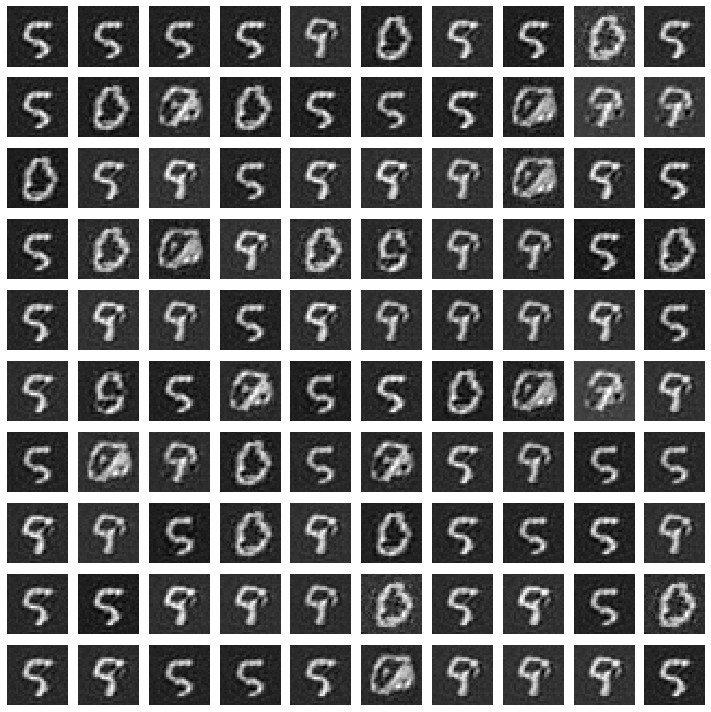

In [43]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)